# Introduction

> 
This notebook will deploy the Vulnerability analysis for container security Blueprint using NVIDIA NIM microservices and [NVIDIA Morpheus](https://github.com/nv-morpheus/Morpheus) which demonstrates accelerated analysis on common vulnerabilities and exposures (CVE) at an enterprise scale, reducing mitigation from days and hours to just seconds. You will install the necessary prerequisites, spin up NVIDIA Morpheus SDK and NVIDIA NIM™ microservices on 4xA100 GPU nodes. For improved paralleled performance, we recommend 8x or more H100s for inference. Depending on the application, the Morpheus pipeline operation affords more flexibility on GPU needs.

Once deployed, you will have a fully functional pipeline which determines whether a software package includes exploitable and vulnerable components, be able to run the blueprint on an example input including viewing the results from an output file with all the gathered and generated information for a final review by the security analyst.


# Getting Started
>[Prerequisites](#Prerequisites)  
>[Spin Up Blueprint](#Spin-Up-Blueprint)  
>[Running the workflow](#Running-the-workflow)  
>[Validate Deployment](#Validate-Deployment)  
>[API Reference](#API-Reference)  
>[Next Steps](#Next-Steps)  
>[Appendix](#Appendix)  
________________________


## Prerequisites

- NVAIE developer license
- API keys for vulnerability databases, search engines, and LLM model service(s).
  - Details can be found in this later section: [Obtain API keys](#obtain-api-keys)

### Hardware requirements
The vulnerability analysis pipeline supports the following hardware:

- Pipeline operation: 1x L40 GPU recommended
- LLM NIM: [Meta Llama 3 70B Instruct Support Matrix](https://docs.nvidia.com/nim/large-language-models/latest/support-matrix.html#meta-llama-3-70b-instruct)(Optional).
       For improved paralleled performance, we recommend 8x or more H100s for LLM inference.
       The pipeline can share the GPU with the LLM NIM, but it is recommended to have a separate GPU for the LLM NIM for optimal performance.
- Embedding NIM: [NV-EmbedQA-E5-v5 Support Matrix](https://docs.nvidia.com/nim/nemo-retriever/text-embedding/latest/support-matrix.html#nv-embedqa-e5-v5) (Optional).
       The pipeline can share the GPU with the Embedding NIM, but it is recommended to have a separate GPU for the Embedding NIM for optimal performance.

### Clone repository and Modify Deployment Files

1. **Clone** <name> workflow repository

In [ ]:
!git clone https://github.com/NVIDIA-AI-Blueprints/vulnerability-analysis.git

In [ ]:
%cd vulnerability-analysis/

2. **Set** <name> up the workflow repository

In [2]:
#set an environment variable for the path to the repository root.
import os
os.environ['REPO_ROOT'] = '/home/ubuntu/vulnerability-analysis'

<div class="alert alert-block alert-success">
    <b>Tip:</b> All commands are run from the repository root unless otherwise specified.

### Get an API Key
To run the pipeline, you need to obtain API keys for the following APIs. These will be needed in a later step to Set up the environment file.




- **Vulnerability databases and search engines**: These APIs are required by the pipeline to retrieve vulnerability information from databases and online search.
  
   - [GitHub Security Advisory (GHSA) Database](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens#creating-a-fine-grained-personal-access-token)
        - Follow [these](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens#creating-a-fine-grained-personal-access-token) instructions to create a personal access token. No repository access or permissions are required for this API. This will be used in the `GHSA_API_KEY` environment variable.
   - [National Vulnerability Database (NVD)](https://nvd.nist.gov/developers/request-an-api-key) 
        - Follow [these](https://nvd.nist.gov/developers/request-an-api-key) instructions to create an API key. This will be used in the `NVD_API_KEY` environment variable.
   - [SerpApi](https://serpapi.com/)
        - Go to (https://serpapi.com/) and create a SerpApi account. Once signed in, navigate to Your Account > Api Key. This will be used in the `SERPAPI_API_KEY` environment variable.


### NVIDIA Inference Microservices (NIM)
The workflow requires LLM API calls for model inference. By default, the workflow uses NVIDIA Inference Microservices (NIMs) APIs, which provide optimized inference for each model.

There are two possible methods to generate an API key for NIM:
1. Through [the NVIDIA Build](https://build.nvidia.com/explore/discover?signin=true) portal with your email
2. Through [NVIDIA NGC portal](https://ngc.nvidia.com/) with your email

In this notebook, the API Key generation via [the NVIDIA Build](https://build.nvidia.com/explore/discover?signin=true)  is explained.
The NVIDIA NGC API Key is required to log in to the NVIDIA container registry, nvcr.io, and to pull secure base container images used in this NIM Blueprint.  Perform the following steps if you do not already have an API key. You can use different model API endpoints with the same API key. This will be used in the `NVIDIA_API_KEY` environment variable.

1. Navigate to **[NVIDIA API Catalog](https://build.nvidia.com/explore/discover)**.

2. Select a model, such as llama3-8b-instruct.
   

3. Select an **Input** option. The following example is of a model that offers a Docker option. Not all of the models offer this option, but all include a “Get API Key” link

<img src="https://docscontent.nvidia.com/dims4/default/d6307a8/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_docker_tab.png" />

3. Click **Get API Key**.

<img src="https://docscontent.nvidia.com/dims4/default/c6e2096/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_get_api_key.png" />

4. Select **"Generate Key"**

<img src="https://docscontent.nvidia.com/dims4/default/e7c4057/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_generate_key.png" />

5. **Copy your key** and store it in a secure place. Do not share it.

<img src="https://docscontent.nvidia.com/dims4/default/4b0710a/2147483647/strip/true/crop/1920x919+0+0/resize/2880x1378!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000192-bfa6-da2c-a1f2-ffbf41aa0000%2Fnim%2Flarge-language-models%2Flatest%2F_images%2Fbuild_copy_key.png" />

<div class="alert alert-block alert-success">
    <b>Tip:</b> The key begins with the letters nvapi-.

## Spin Up Blueprint
In this step, we'll export the necessary API keys into the terminal and build our vulnerability analysis container. We'll also build our NIM Containers for LLM and Embedding. This step will take **several minutes**. Finally, we'll deploy all of the containers onto the workstation. 


Set up the **environment file**

In [3]:
%%bash
cd $REPO_ROOT
cat <<EOF > .env
GHSA_API_KEY="API-KEY-HERE"
NVD_API_KEY="API-KEY-HERE"
NVIDIA_API_KEY="API-KEY-HERE"
SERPAPI_API_KEY="API-KEY-HERE"
EOF

In [4]:
%%bash
export $(cat .env | xargs)

Export **API Key**

To download the appropriate models and resources, you will need to set NGC_API_KEY environment variable. This will allow you to pass the API key value to a docker run command.

In [ ]:
%%bash
export NGC_API_KEY="API-KEY-HERE"
echo "${NGC_API_KEY}" | docker login nvcr.io -u '$oauthtoken' --password-stdin

Use oauthtoken as the username and your API key as the password. The $oauthtoken username is a special name that indicates that you will authenticate with an API key and not a user name and password

Build the <name> **docker container**

In [6]:
%%bash
cd $REPO_ROOT

# Build the morpheus-vuln-analysis container
# docker compose build morpheus-vuln-analysis

<div class="alert alert-block alert-success">
    <b>Tip:</b> Refer to the deploy/compose/docker-compose.yml for complete details.

## Running the workflow

To run the workflow, there are two supported configurations. Both configurations utilize `docker compose` to start the service:
 - When using NVIDIA-hosted NIMs, only the `docker-compose.yml` configuration file is required. This is the default configuration and is recommended for most users getting started with the workflow.
 - When using self-hosted NIMs, both the `docker-compose.yml` and `docker-compose.nim.yml` configuration files are required.

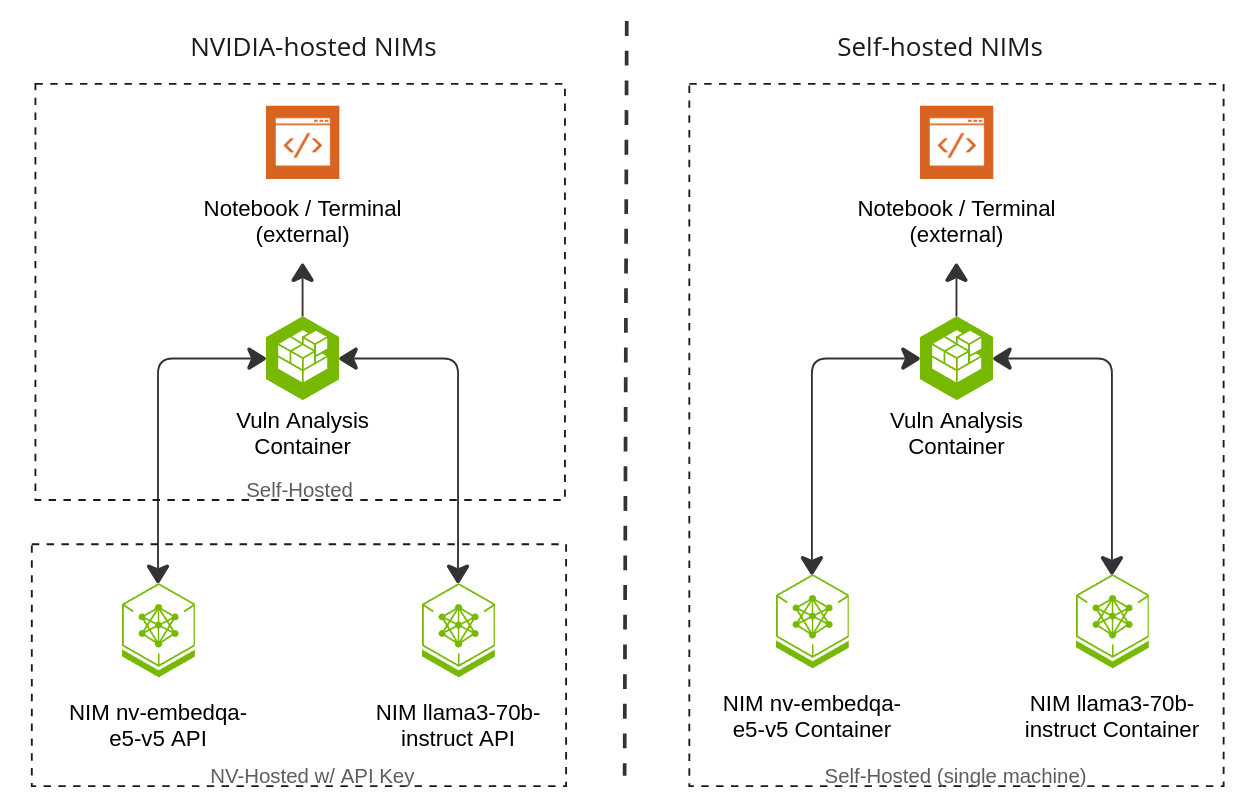

<div class="alert alert-block alert-success">
    <b>Tip:</b> The container binds to port 8080 by default. If you encounter a port collision error (e.g. Bind for 0.0.0.0:8080 failed: port is already allocated), you can set the environment variable NGINX_HOST_HTTP_PORT to specify a custom port before launching docker compose. For example:

In [7]:
!export NGINX_HOST_HTTP_PORT=8081

#... docker compose commands...

## For this Launchable: Use <name> **NVIDIA-hosted NIMs** and run the pipeline locally via this instance! 

Open up a JupyterLab terminal. To do this, you'll need to open a new terminal in your JupyterLab. You can do this by selecting the `+` icon in the file explorer tab to the left and clicking on the `Terminal` button. It will also help to split the display such that your terminal is visible next to this notebook side-by-side. 

Run the following commands:
#### `cd vulnerability-analysis`

#### `docker compose -f ./docker-compose.yml up -d`

## OPTIONAL SECTION : Pull <name> **Self-hosted NIMs**

***NOTE***: If you want to self-host this entire blueprint, you will need an 8xH100 instance at minimum. Multiple nodes are highly recommended!

In [ ]:
#docker compose -f deploy/compose/docker-compose.yml -f deploy/compose/docker-compose.nim.yml pull nim-llm nim-embed

<div class="alert alert-block alert-info">
    <b>Note:</b> The self-hosted NIM services require additional GPU resources to run. With this configuration, the LLM NIM, embedding model NIM, and the morpheus-vuln-analysis service will all be launched on the same machine. Ensure that you have the necessary hardware requirements for all three services before proceeding (multiple services can share the same GPU).

For example, to start the `morpheus-vuln-analysis` service with the self-hosted NIMs, you would run:

In [ ]:
#cd ${REPO_ROOT}
#docker compose -f docker-compose.yml -f docker-compose.nim.yml up -d

In [ ]:
#docker compose -f deploy/compose/docker-compose.yml exec morpheus-vuln-analysis pip install click

#docker compose -f deploy/compose/docker-compose.yml -f deploy/compose/docker-compose.nim.yml exec morpheus-vuln-analysis pip install click

Deploy <name> **microservices**

In [ ]:
#docker compose -f deploy/compose/docker-compose.yaml up -d --build

<div class="alert alert-block alert-success">
    <b>Tip:</b> If you would like to monitor progress, refer to https://docs.docker.com/reference/cli/docker/compose/logs/.

<div class="alert alert-block alert-info">
    <b>Note:</b> By default, the blueprint uses the NVIDIA API Catalog hosted endpoints for LLM,and embedding models.

To validate the deployment of the blueprint, execute the following command to ensure the container are running.

If the deployment was successful, you should see four running containers for the Morpheus pipeline, LLM NIM, Embed NIM, and the request caching server when running the following command:

In [ ]:
!docker compose ps

```bash
NAME                                              COMMAND                  SERVICE                  STATUS              PORTS
morpheus_vuln_analysis-morpheus-vuln-analysis-1   "/opt/conda/envs/mor…"   morpheus-vuln-analysis   running             0.0.0.0:8888->8888/tcp, 0.0.0.0:26466->26466/tcp, :::8888->8888/tcp, :::26466->26466/tcp
morpheus_vuln_analysis-nginx-cache-1              "/docker-entrypoint.…"   nginx-cache              running             0.0.0.0:8080->80/tcp, :::8080->80/tcp
```

## Starting the Workflow

Now that the containers are up and running, the next step is to get the Morpheus Vulnerability Analysis pipeline running in the Morpheus container, and listening for HTTP summarization requests. 

To run the workflow from the command line, you can use the provided CLI tool. In order to use the CLI tool, we must first attach to the `morpheus-vuln-analysis` container.

Go to the JupyterLab Terminal and run:
`docker compose exec -it morpheus-vuln-analysis bash`

## Validate Deployment
In that terminal you have opened, run the following command to start the pipeline and have it listen as an HTTP server to make it is up and running and ready to receive requests

Run the following commands:
- `cp configs/from_http.json .tmp/http_config.json` and
- `python src/main.py --log_level DEBUG cve pipeline --config_file=.tmp/http_config.json`

<div class="alert alert-block alert-info">
    <b>Note:</b> This command starts an HTTP server that listens on port 26466 and runs the workflow indefinitely, waiting for incoming data to process. This is useful if you want to trigger the workflow on demand via HTTP requests.

You should see the pipeline start to run with runtime counters ticking up like so:
```bash
Http Server Started for POST at 0.0.0.0:26466
                            /scan.
====Pipeline Pre-build====
====Pre-Building Segment: linear_segment_0====
====Pre-Building Segment Complete!====
====Pipeline Pre-build Complete!====
====Registering Pipeline====
Source: 0 messages [00:00, ? messages/s]====Building Pipeline====
Source: 0 messages [00:00, ? messages====Building Pipeline Complete!====                    
```

<div class="alert alert-block alert-info">
    <b>Note:</b> Keep this terminal open to keep the process running. It'll also be helpful as you can monitor the agents' thoughts and outputs as they recieve requests.

We'll issue our first vulnerability analysis request to the pipeline, which, by default will run the triage on the Morpheus 23.11 container release. Let's first explore what a request to the pipeline looks like:

In [ ]:
cat data/input_messages/morpheus:23.11-runtime.json

Above, we see that we are indeed asking for a vulnerability triage on the Morpheus 23.11.01-runtime container, giving the Agent context from all of the container's source code, documentation, build files, and even python notebooks. Furthermore, we include a Software Bill of Materials (SBOM) for package version identification, and a list of vulnerabilities to scan for. Let's issue a request with the above configuration. Be sure to keep an eye on the terminal to watch the agent reason and look at the output.


<div class="alert alert-block alert-info">
    <b>Note:</b> Your first analysis request for any new container or CVE could take several minutes as the service builds and creates a request cache for you. It is also possible to encounter 404 or 503 errors when issuing the request. Please refer to the Troubleshooting section at the end of this notebook for additional guidance. If you notice a 502 from the nginx service when issuing the request, please wait a few minutes and try again.


In [ ]:
! curl -v -X POST http://0.0.0.0:26466/scan -d @data/input_messages/morpheus:24.03-runtime.json

When you make the curl request, you will see something like below as the pipeline is scanning the container:

```bash
===========================
Collecting documents from git repos. Source Infos: [{"type": "code", "git_repo": "https://github.com/nv-morpheus/Morpheus.git", "tag": "v23.11.01", "include": ["**/*.cpp", "**/*.cu", "**/*.cuh", "**/*.h", "**/*.hpp", "**/*.ipynb", "**/*.py", "**/*Dockerfile"], "exclude": ["tests/**/*"]}]
Cloning repository from URL: 'https://github.com/nv-morpheus/Morpheus.git' for branch/tag 'v23.11.01'
Source: 0 messages [12:39, ? messagesLoaded Git repository at path: '.cache/am_cache/git/https:/github.com/nv-morpheus/Morpheus.git' for branch/tag 'v23.11.01'
Scanning documents for Git repository at path: '.cache/am_cache/git/https:/github.com/nv-morpheus/Morpheus.git'
Source: 0 messages [12:41, ? messages/s]                                                                                                                                                                                                                                            Processing 615 files in the Git repository at path: '.cache/am_cache/git/https:/github.com/nv-morpheus/Morpheus.git'
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 615/615 [00:08<00:00, 70.27it/s]
Collected documents for '.cache/am_cache/git/https:/github.com/nv-morpheus/Morpheus.git', Document count: 2250
Creating FAISS database from source documents. Doc count: 2250, Chunks: 7965, Location: .cache/am_cache/vdb/code/ddb7e6a2171ab6bc████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 611/615 [00:08<00:00, 71.76it/s]
```                   

Exploring <name> the **Output of the Pipeline**

Upon completion of the pipeline, you should see messages similar to the following, depending on the CVE you submitted in the previous step. The output is stashed by default at `.tmp/output.json`. Sample logs are as follows:

```bash
Vulnerability 'GHSA-3f63-hfp8-52jq' affected status: FALSE. Label: code_not_present
Vulnerability 'CVE-2024-51301' affected status: FALSE. Label: code_not_reachable
Vulnerability 'CVE-2023-36632' affected status: FALSE. Label: code_not_present
Vulnerability 'CVE-2023-43804' affected status: FALSE. Label: code_not_present
Vulnerability 'GHSA-cxfr-5q3r-2rc2' affected status: FALSE. Label: code_not_present
Vulnerability 'GHSA-554w-xh4j-8w64' affected status: FALSE. Label: code_not_present
Vulnerability 'GHSA-3ww4-gg4f-jr7f' affected status: FALSE. Label: code_not_present
```

In [ ]:
! cat .tmp/output.json

3. After testing queries, explore the output of the pipeline. 

In [21]:
import json
with open('.tmp/output.json', 'r') as result_in:
    scan_results = json.load(result_in)

In [ ]:
# Print the structure of the results
print(json.dumps(scan_results, indent=2))

# Or see the keys at the top level
print(scan_results.keys())

To support operational requirements, the blueprint includes reference code for managing key administrative tasks such as generating conversation summaries and conducting sentiment analysis.  This is accomplished using a analytics server which offers three APIs:  

>- /sessions - lists all sessions from the last k hours
>- /session/summary - provides summary and sentiment analysis for a given session's conversation
>- /session/conversation - offers sentiment analysis for individual queries and responses

4. Explore the vulnerability analysis outputs using Llama3.1-70B!

In [ ]:
%cd vulnerability-analysis/

In [ ]:
from openai import OpenAI
import json

# Initialize NVIDIA API client
client = OpenAI(
    api_key="API-KEY-HERE",
    base_url="https://integrate.api.nvidia.com/v1"
)

# Load vulnerability data
with open('.tmp/output.json', 'r') as f:
    data = json.load(f)

# Format the context once
context = ""
for vuln in data['output']:
    context += f"""
Vulnerability ID: {vuln['vuln_id']}
Summary: {vuln['summary']}
Justification: {vuln['justification']['label']}
Reason: {vuln['justification']['reason']}
Status: {vuln['justification']['status']}
"""

# Create completion
prompt = """Based on the following vulnerability information:
{}
Question: What vulnerabilities were found to be exploitable?
Please provide a detailed answer focusing on the vulnerability details provided.""".format(context)

completion = client.chat.completions.create(
    model="meta/llama-3.1-70b-instruct",
    messages=[
        {"role": "system", "content": "You are a security expert analyzing vulnerability reports."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.5,
    top_p=1,
    max_tokens=1024,
    stream=True
)

# Print the response
for chunk in completion:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="")

## API Reference
For detailed API references, please refer to the following locations in the current directory:
>- Summary & Conversation APIs:
./docs/api_references/analytics_server.json

>- Generate API:
./docs/api_references/agent_server.json


# Next Steps

Open the **2_workflow_customization.ipynb** notebook.  Within this notebook you will customize the workflow to generate a new configuration file, define the pipeline settings, such as the input data, the LLM models used, and the output format. You will also be able to swap in CVE IDs and custom code repository.

# Appendix
________________________

## NGINX caching server

The docker compose file includes an nginx-cache proxy server container that enables caching for API requests made by the workflow. It is highly recommend to route API requests through the proxy server to reduce API calls for duplicate requests and improve workflow speed. This is especially useful when running the pipeline multiple times with the same configuration (e.g., for debugging) and can help keep costs down when using paid APIs.

The NGINX proxy server is started by default when running the `morpheus-vuln-analysis` service. However, it can be started separately using the following command:

```bash
cd ${REPO_ROOT}
docker compose up --detach nginx-cache
```

## Troubleshooting


Several common issues can arise when running the pipeline. Here are some common issues and their solutions.

### Git LFS issues

If you encounter issues with Git LFS, ensure that you have Git LFS installed and that it is enabled for the repository. You can check if Git LFS is enabled by running the following command:
```bash
git lfs install
```

Verifying that all files are being tracked by Git LFS can be done by running the following command:
```bash
git lfs ls-files
```
Files which are missing will show a `-` next to their name. To ensure all LFS files have been pulled correctly, you can run the following command:
```bash
git lfs fetch --all
git lfs checkout *
```

### NGINX caching server

Because the workflow makes such heavy use of the caching server to speed up API requests, it is important to ensure that the server is running correctly. If you encounter issues with the caching server, you can reset the cache.

#### Resetting the entire cache

To reset the entire cache, you can run the following command:
```bash
docker compose -f docker-compose.yml -f docker-compose.nim.yml down -v
```
This will delete all the volumes associated with the containers, including the cache.

#### Resetting just the LLM cache or the services cache

If you want to reset just the LLM cache or the services cache, you can run the following commands:
```bash
docker compose -f docker-compose.yml down

# To remove the LLM cache
docker volume rm ${COMPOSE_PROJECT_NAME:-morpheus_vuln_analysis}-llm-cache

# To remove the services cache
docker volume rm ${COMPOSE_PROJECT_NAME:-morpheus_vuln_analysis}-service-cache
```

### Service outages

#### National Vulnerability Database (NVD)
These typically resolve on their own. Please wait and try running the pipeline again later. Example errors:

404
```
Error requesting [1/10]: (Retry 0.1 sec) https://services.nvd.nist.gov/rest/json/cves/2.0: 404, message='', url=URL('https://services.nvd.nist.gov/rest/json/cves/2.0?cveId=CVE-2023-6709')
```

503
```
Error requesting [1/10]: (Retry 0.1 sec) https://services.nvd.nist.gov/rest/json/cves/2.0: 503, message='Service Unavailable', url=URL('https://services.nvd.nist.gov/rest/json/cves/2.0?cveId=CVE-2023-50447')
```

<div class="alert alert-block alert-info">
    <b>Note:</b> By default, GPU IDs 0-3 are for LLM, 4 for the embedding model, and 5 for the reranking model.
    
>To change the GPUs used for NIM deployment, set the following environment variables:

>>**LLM_MS_GPU_ID**: Update this to specify the LLM GPU IDs (e.g., 0,1,2,3).

>>**EMBEDDING_MS_GPU_ID**: Change this to set the embedding GPU ID.
>>
>>**RANKING_MS_GPU_ID**: Modify this to adjust the reranking LLM GPU ID.